# Generative Adversarial Network (GAN): an application on human faces
\\
*Generative adversarial networks* are used to generate images that never existed before: they learn about the world through real images (objects, animals, faces, etc), and create new versions of those images that never existed.

They have two fundamental components:

* **Generator**: creates the images by taking as input a random noise signal;
* **Discriminator**: assess the images and tells the generator if they are similar to what it has been trained on. These are based off real world examples.

When training the network, both the generator and discriminator start from scratch and learn together.

This project, in particular, applies a **Deep Convolutional GAN** architecture (also known as DCGAN), since it implements deep convlutional neural networks layers which better capture local structures in images, resulting in better image quality and stability during training.

In this case study the real world examples on which the model components will be trained are 30'000 images of celebrity faces. The goal is to generate new human faces that, of course, do not exist.



In [ ]:
%matplotlib inline
import argparse
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML

### Mounting drive and unzipping the image folder

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

# Zip path on drive
zip_file_path = '/content/drive/MyDrive/digital signal and image management progetto/celeb_folder.zip'

# File extraction path
extract_path = '/content/extracted/'

# Making sure directory exists
os.makedirs(extract_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
# File extraction from specified path
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Set random seed for reproducibility
seed = 8104
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  8104


### DCGAN model parameters definition
\\
In the next cell, the parameters of the model, which are going to be used to define the structure of both the generator and discriminator, as well as implemented in the training phase, will be set.

The defined parameters are the following:

* **dataroot**: root directory for the dataset
* **workers**: number of workers for dataloader
* **batch_size**: batch size implemented in training
* **image_size**: spatial size of training images. All images will be resized to this size using a transformer.
* **nc**: number of channels
* **nz**: size of z latent vector (i.e. size of generator input)
* **ngf**: size of feature maps in generator
* **ndf**: size of feature maps in discriminator
* **num_epochs**: number of training epochs
* **lr**: learning rate for optimizers
* **beta1**: beta hyperparameter for Adam optimizers
* **num_gpu**: number of gpu to implement, in this case 1




In [ ]:
# Parameters
dataroot = extract_path
workers = 2
batch_size = 125
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 150
lr = 0.0002
beta1 = 0.5
num_gpu= 1

In [ ]:
# Removing '__MACOSX' directory and its content, if it exists
macosx_path = os.path.join(extract_path, '__MACOSX')
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)

This directory was causing an error during the display of images in the next code cells, so it has been removed

### Dataset and data loader definition
\\
In the next cell the image **dataset** and the **data loader** are defined. Starting from the dataset creation, the images are uploaded from the specified directory ('dataroot') and subject to a series of transformations, according to the parameters set before, and normalization.
\
Then the data loader is created, taking the dataset, batch size and number of workers as arguments.

Finally, 64 random images from the dataloader are displayed in a 8x8 grid.

Using device: cuda:0
Tesla T4


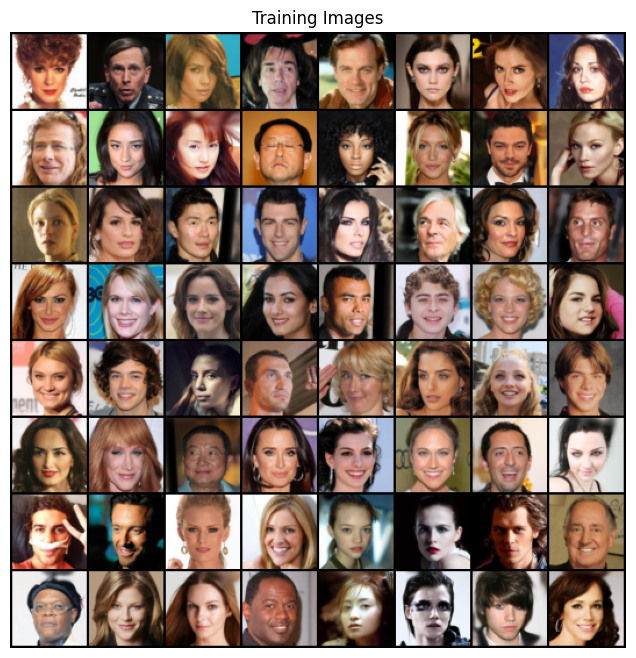

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
          transform=transforms.Compose([
          transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weights definition
\\
Weights definition is an essential part of building and training neural networks as it can prevent common issues, such as simmetry breaking, vanishing/exploding gradients, improve convergence, and, overall, provide training stability.

In [ ]:
# Custom weights initialization

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator structure definition
\\
In the next code cell, the structure of the generator is defined. As mentioned before, this component is fundamental in GAN models because it helps train the discriminator by providing generated images. These images become progressively similar to real ones as the generator learns from its mistakes through the errors backpropagated by the discriminator.

Specifically, since a DCGAN is being implemented, the generator follows a deep convolutional architecture and it is structured in five layers, which progressively generate bigger feature maps through gradual trasformations: starting from a 4x4 spatial dimension, a final 64x64 spatial dimension is reached, and the generator outputs an image.

To determine the spatial dimensions of the feature maps through the layers, the following formula for the output height $H_{\text{out}}$ and widht $W_{\text{out}}$ is applied:


* $H_{\text{out}} = (H_{\text{in}} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel size}$

* $W_{\text{out}} = (W_{\text{in}} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel size}$

Where:
* $H_{\text{in}}$ and $W_{\text{in}}$ are the height and width of the input.
* $\text{stride}$ is the stride of the convolution.
* $\text{padding}$ is the padding added to the input.
* $\text{kernel size}$ is the size of the convolutional kernel.


In [ ]:
class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()
        self.num_gpu= num_gpu
        self.main = nn.Sequential(
            # First layer, spatial dimension 4x4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Second layer, spatial dimension 8x8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Third layer, spatial dimension 16x16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Fourth layer, spatial dimension 32x32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # Fifth layer, spatial dimension 64x64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
gen = Generator(num_gpu).to(device)

# Apply the weights function to randomly initialize all weights to mean=0, stdev=0.2.
gen.apply(weights_init)

# Print the model
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

### Discriminator structure defnition
\\
Now, similarly to the generator, the structure of the discriminator is defined. As said in the introduction, this component is crucial in GAN models because it can identify the real images from the generated ones and outputs a probability - which at the start of the training can be very high, since the fake images are far from the real ones in terms of similarity - indicating whether the image is real or not.

In the context of a DCGAN discriminator, the same logic applies as the definition of the generator: this time, though, starting from a larger spatial dimension, which is going to be the same as the output of the generator, since the latter one feeds the former with images. Again, the structure is composed of five layers, taking as first input a 64x64 image - outputted by the generator - and progressively reducing the dimension through each layer unitl reaching a 4x4 feature map, which also represents the probability that the image is real or generated.

To determine the spatial dimensions of the feature maps, the following formula for the output height $H_{\text{out}} $ and width $W_{\text{out}}$ is implemented:

* $H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{kernel size}}{\text{stride}} \right\rfloor + 1 $

* $W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding} - \text{kernel size}}{\text{stride}} \right\rfloor + 1 $

Where:
* $H_{\text{in}}$ and $W_{\text{in}}$ are the height and width of the input feature map.
* $\text{stride}$ is the stride of the convolution.
* $\text{padding}$ is the padding added to the input feature map.
* $\text{kernel size}$ is the size of the convolutional kernel.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()
        self.num_gpu= num_gpu
        self.main = nn.Sequential(
            # First layer, spatial dimension 64x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Second layer, spatial dimension 32x32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Third layer, spatial dimension 16x16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Fourth layer, spatial dimension 8x8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Fifth layer, spatial dimension 4x4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
dis = Discriminator(num_gpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
dis.apply(weights_init)

# Print the model
print(dis)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Initializing BCELoss function and optimizers

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(dis.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # Initialize the accumulators for statistics
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_x_total = 0.0
    D_G_z1_total = 0.0
    D_G_z2_total = 0.0
    num_batches = len(dataloader)

    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

                        ###############################################################
                        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
                        ###############################################################

        # Train with all-real batch
        dis.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)
        # Forward pass real batch through Discriminator
        output = dis(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with Discriminator
        output = dis(fake.detach()).view(-1)
        # Calculate Discriminator loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update Discriminator
        optimizerD.step()

                                ###############################################
                                # (2) Update G network: maximize log(D(G(z))) #
                                ###############################################

        gen.zero_grad()
        label.fill_(real_label)
        # Perform another forward pass of all-fake batch through Discriminator
        output = dis(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for Generator
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()

        # Accumulate the losses and statistics
        epoch_D_loss += errD.item()
        epoch_G_loss += errG.item()
        D_x_total += D_x
        D_G_z1_total += D_G_z1
        D_G_z2_total += D_G_z2

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Print the statistics at the end of each epoch
    print(f'[{epoch + 1}/{num_epochs}] '
          f'Loss_D: {epoch_D_loss / num_batches:.4f} '
          f'Loss_G: {epoch_G_loss / num_batches:.4f} '
          f'D(x): {D_x_total / num_batches:.4f} '
          f'D(G(z)): {D_G_z1_total / num_batches:.4f} / {D_G_z2_total / num_batches:.4f}')

Starting Training Loop...


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1/150] Loss_D: 0.8215 Loss_G: 7.4725 D(x): 0.7999 D(G(z)): 0.2086 / 0.0301
[2/150] Loss_D: 0.7497 Loss_G: 4.2315 D(x): 0.7693 D(G(z)): 0.2287 / 0.0574
[3/150] Loss_D: 0.6677 Loss_G: 3.5728 D(x): 0.7789 D(G(z)): 0.2169 / 0.0863
[4/150] Loss_D: 0.6608 Loss_G: 3.3857 D(x): 0.7798 D(G(z)): 0.2173 / 0.0926
[5/150] Loss_D: 0.8442 Loss_G: 2.9111 D(x): 0.7278 D(G(z)): 0.2689 / 0.1370
[6/150] Loss_D: 0.8078 Loss_G: 2.7641 D(x): 0.7355 D(G(z)): 0.2623 / 0.1465
[7/150] Loss_D: 0.7615 Loss_G: 2.6513 D(x): 0.7530 D(G(z)): 0.2438 / 0.1531
[8/150] Loss_D: 0.6926 Loss_G: 2.7445 D(x): 0.7636 D(G(z)): 0.2333 / 0.1478
[9/150] Loss_D: 0.7343 Loss_G: 2.8761 D(x): 0.7577 D(G(z)): 0.2393 / 0.1399
[10/150] Loss_D: 0.6977 Loss_G: 2.8205 D(x): 0.7633 D(G(z)): 0.2372 / 0.1317
[11/150] Loss_D: 0.7413 Loss_G: 2.7743 D(x): 0.7542 D(G(z)): 0.2434 / 0.1393
[12/150] Loss_D: 0.7538 Loss_G: 2.7512 D(x): 0.7477 D(G(z)): 0.2502 / 0.1401
[13/150] Loss_D: 0.7726 Loss_G: 2.7386 D(x): 0.7472 D(G(z)): 0.2529 / 0.1496
[14/150]

### Generator and Discriminator Losses

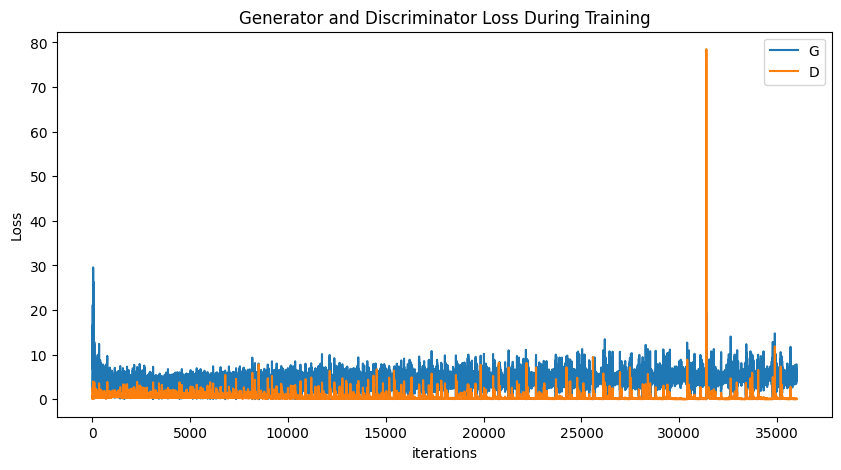

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

* Note:
\
Both Generator and Discriminator losses seems to better over the iterations - i.e. the difference between the output and the real labels for the former, and the difference between the output and the fake labels for the latter are decreasing - altough the discriminator registered a huge loss around the 32000th iteration: considered the fact that the resulting images are acceptable, the model was not changed.    

### Final results

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Some observations on the results (random batch):
* The general output is acceptable, meaning that most faces are interpretable as human-like.
* The difference between male and female faces is, in most cases, clear.
* Male faces seems to be more plausible than female ones  (maybe some anatomic elements makes the generation process easier, i.e. shorter or less elaborated hairstyles, as well as the absence of makeup, or perhaps there are more male faces than female ones in the dataset).

### Real vs Generated images

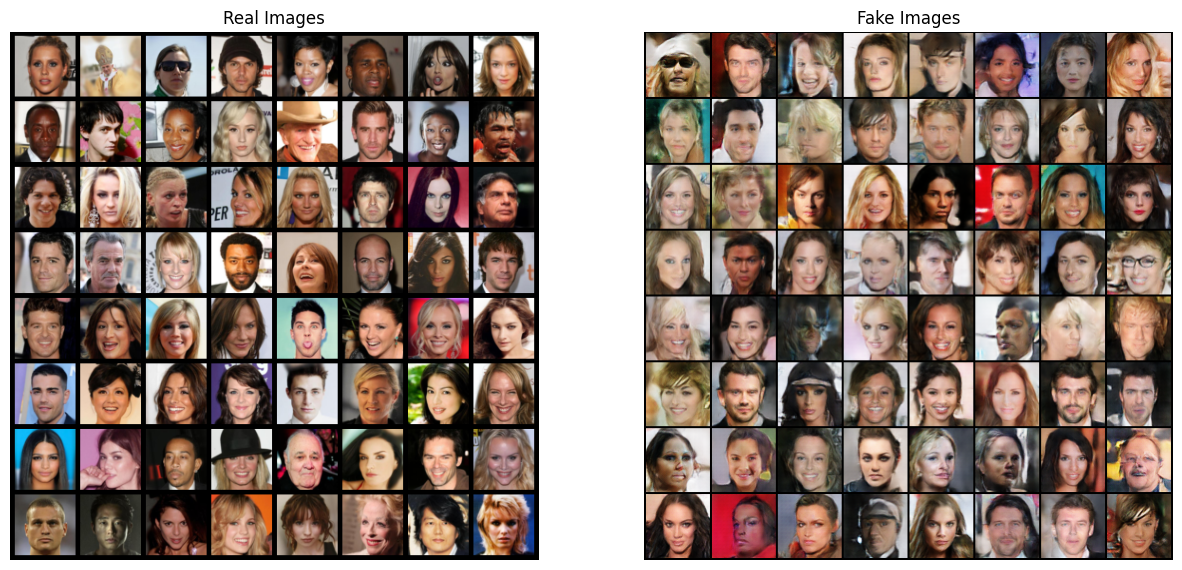

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Saving training progress (generator and discriminator losses)
torch.save(G_losses, '/content/drive/My Drive/digital signal and image management progetto/Training progress/Losses/G_losses.pt')
torch.save(D_losses, '/content/drive/My Drive/digital signal and image management progetto/Training progress//Losses/D_losses.pt')

In [ ]:
# zip file destination
zip_folder = '/content/drive/My Drive/digital signal and image management progetto/Training progress/Fake Images'
zip_file_path = os.path.join(zip_folder, 'images.zip')

# zip creation
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for i, img_tensor in enumerate(img_list):
        img_pil = TF.to_pil_image(img_tensor)
        img_path = os.path.join(zip_folder, f'image_{i}.png')
        img_pil.save(img_path)
        zipf.write(img_path, arcname=f'image_{i}.png')
        os.remove(img_path)

print("Immagini compresse con successo in:", zip_file_path)

Immagini compresse con successo in: /content/drive/My Drive/DSIM Project/Training progress/Fake Images/images.zip
